In [298]:
import gym
import numpy as np

env = gym.make('CartPole-v0')
observation = env.reset()
def run(env, policy, rewarder=Rewarder(), render = False):
    reward = 0
    observation = env.reset()
    done = False
    count = 0
    observations = [observation]
    while(done == False):        
        action = policy.step(observation, reward)            
        observation, raw_reward, done, info = env.step(action)
        reward = rewarder.get_reward(observation, raw_reward, done, info, count)
        if(render):
            env.render()
        count += 1
        observations += [observation]
#         print(observation, reward, done, info)
    action = policy.step(observation, reward)  # step called to process the final reward
    return count, observations


In [251]:
class Policy(object):
    def step(self, observation, reward):
        return 0

In [249]:
class Rewarder(object):
    def get_reward(self, observation, raw_reward, done, info, count):
        return raw_reward

In [252]:
policy = Policy()
obs = np.vstack([np.vstack(run(env, policy)[1]) for i in range(100)] )

In [253]:
import pandas as pd
pd.DataFrame(obs).describe()

,0,1,2,3
count,1028.000000,1028.000000,1028.000000,1028.000000
mean,-0.049253,-0.910347,0.077599,1.406762
std,0.060814,0.587901,0.081231,0.921379
min,-0.221702,-2.156585,-0.049323,-0.048268
25%,-0.088829,-1.393988,0.013292,0.596620
50%,-0.041635,-0.936842,0.055567,1.418577
75%,-0.001722,-0.394724,0.135145,2.164119
max,0.050084,0.049283,0.269082,3.330385


In [284]:
class QLearningPolicy(Policy):
    def __init__(self, gamma = 0.9, lr = 0.3, epsilon = 0.2, box_size = 1, verbose = False):
        self.q = {}
        self.last_state_action=None
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.verbose = verbose
        self.box_size = box_size 
    
    def step(self, observation, reward):        
        weights = self.box_size * np.array([0.062775 ,0.593712,0.082334,0.928363])  # std for each dimension
        normalized = observation / weights
        floored = np.floor(normalized)
        s = str(floored)
        
        self.update(reward, s)
        
        a = 0 if self.evaluate(s+str(0)) > self.evaluate(s+str(1)) else 1
        if np.random.rand() < self.epsilon:
            a = np.random.choice([0,1])
        
        self.last_state_action = s+str(a)
        return a
    
    def evaluate(self, key):        
        if key not in self.q:
            self.q[key] = 0
        return self.q[key]
    
    def update(self, reward, s):
        lr = self.lr
        if self.last_state_action is None:
            return
        old = self.q[self.last_state_action]
        new = reward + self.gamma * max([self.evaluate(s+str(a)) for a in [0,1]])        
        self.q[self.last_state_action] = lr * new + (1-lr) * old
        if self.verbose:
            print(reward)



In [342]:
class RewardAtEndRewarder(Rewarder):
    def __init__(self, verbose = False):
        self.verbose = verbose
        
    def get_reward(self, observation, raw_reward, done, info, count):
        if count < 200 and done:
            if self.verbose:
                print('Fallen over -> punish (-100)')
            return -100        
        return 0

class CombinedRewarder(Rewarder):
    def __init__(self):
        self.raer = RewardAtEndRewarder()
    
    def get_reward(self, observation, raw_reward, done, info, count):
        return raw_reward + 100 * self.raer.get_reward(observation, raw_reward, done, info, count)

100% (60000 of 60000) |##################| Elapsed Time: 0:18:48 Time:  0:18:48


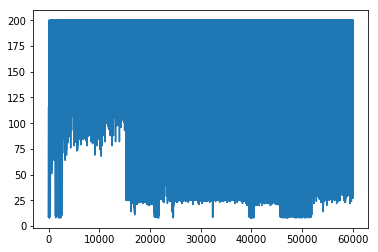

In [347]:
from progressbar import progressbar
p = QLearningPolicy(lr=0.3, epsilon=0, box_size=2)
r = RewardAtEndRewarder()
# r = CombinedRewarder()
results = [run(env, p, rewarder=r)[0] for i in progressbar(range(60000))]
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(results)

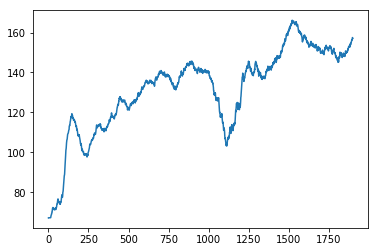

In [346]:
window_size = 100
plt.plot(np.convolve(results, np.ones(window_size)/window_size, mode='valid'))

In [330]:
len(p.q)  # qtable size

2854

In [306]:
# p.verbose = True
r.verbose = True
run(env, p, rewarder=r, render=True)

Fallen over -> punish (-100)


(185,
 [array([-0.04639992,  0.02770723,  0.0090869 ,  0.04021288]),
  array([-0.04584577,  0.22269771,  0.00989116, -0.24958924]),
  array([-0.04139182,  0.02743591,  0.00489937,  0.04619708]),
  array([-0.0408431 ,  0.22248727,  0.00582332, -0.24493604]),
  array([-0.03639335,  0.02728263,  0.00092459,  0.049578  ]),
  array([-0.0358477 ,  0.22239131,  0.00191615, -0.24281306]),
  array([-0.03139988,  0.02724204, -0.00294011,  0.05047365]),
  array([-0.03085503,  0.22240603, -0.00193063, -0.24313545]),
  array([-0.02640691,  0.0273117 , -0.00679334,  0.04893788]),
  array([-0.02586068,  0.2225304 , -0.00581458, -0.24588064]),
  array([-0.02141007,  0.02749198, -0.0107322 ,  0.04496257]),
  array([-0.02086023,  0.22276617, -0.00983295, -0.25108705]),
  array([-0.01640491,  0.027786  , -0.01485469,  0.03847823]),
  array([-0.01584919,  0.22311778, -0.01408512, -0.25885424]),
  array([-0.01138683,  0.02819972, -0.01926221,  0.02935297]),
  array([-0.01082284,  0.22359253, -0.01867515, -

In [ ]:
p.verbose = False
r.verbose = False

In [341]:
p.q

{'[-1.  0. -1.  0.]0': 9.207478824167085,
 '[-1.  0. -1.  0.]1': -3.3380026026184155,
 '[-1.  0. -1. -1.]0': 8.436782008032516,
 '[-1.  0. -1. -1.]1': -9.302306377487465,
 '[ 0.  0. -1. -1.]0': 9.417910358173742,
 '[ 0.  0. -1. -1.]1': -27.54754185358508,
 '[ 0.  1. -1. -2.]0': -47.00761400407529,
 '[ 0.  1. -1. -2.]1': -48.20689426894386,
 '[ 0.  1. -2. -2.]0': -31.397686157093155,
 '[ 0.  1. -2. -2.]1': -76.91665331955043,
 '[0. 0. 0. 0.]0': 0,
 '[0. 0. 0. 0.]1': 9.336860631519542,
 '[ 0.  0.  0. -1.]0': -4.2210624440215,
 '[ 0.  0.  0. -1.]1': 9.03806570908117,
 '[ 0.  1. -1. -1.]0': 8.275354393519667,
 '[ 0.  1. -1. -1.]1': -13.3887700760808,
 '[ 1.  1. -1. -2.]0': 1.441206507158228,
 '[ 1.  1. -1. -2.]1': -2.662746733911728,
 '[ 1.  1. -2. -2.]0': -62.519562870568244,
 '[ 1.  1. -2. -2.]1': -40.9563,
 '[-1. -1. -1.  0.]0': 9.756074667298453,
 '[-1. -1. -1.  0.]1': -0.3737742457823052,
 '[ 0.  0. -2. -2.]0': -97.68917324271436,
 '[ 0.  0. -2. -2.]1': -104.771862915192,
 '[-1.  0.  